In [1]:
import sys

sys.path.append("../")

In [2]:
import torch
from torch.utils.data import DataLoader

import hydra

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from src.models.core_models.zero_shot_ris import ZeroShotRIS
from src.data.core_datasets.zeroshot_dataset import ZeroShotDataset

In [3]:
with hydra.initialize(version_base="1.3", config_path="../configs/model"):
    cfg = hydra.compose(config_name="zsseg.yaml")
cfg

{'_target_': 'src.models.image_text_mask_module.ImageTextMaskModule', 'net': {'_target_': 'src.models.core_models.zero_shot_ris.ZeroShotRIS', 'clip_pretrained_path': '${model_pretrained_path}', 'is_hf_model': '${is_hf_model}', 'clip_interpolation_mode': '${import_eval:torchvision.transforms.functional.InterpolationMode.BICUBIC}', 'solo_config': {'MODEL': {'ANCHOR_GENERATOR': {'ANGLES': [[-90, 0, 90]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'NAME': 'DefaultAnchorGenerator', 'OFFSET': 0.0, 'SIZES': [[32, 64, 128, 256, 512]]}, 'BACKBONE': {'FREEZE_AT': 0, 'NAME': 'build_resnet_fpn_backbone'}, 'FPN': {'FUSE_TYPE': 'sum', 'IN_FEATURES': ['res2', 'res3', 'res4', 'res5'], 'NORM': '', 'OUT_CHANNELS': 256}, 'KEYPOINT_ON': False, 'LOAD_PROPOSALS': False, 'MASK_ON': True, 'META_ARCHITECTURE': 'PseudoSOLOv2', 'PANOPTIC_FPN': {'COMBINE': {'ENABLED': True, 'INSTANCES_CONFIDENCE_THRESH': 0.5, 'OVERLAP_THRESH': 0.5, 'STUFF_AREA_LIMIT': 4096}, 'INSTANCE_LOSS_WEIGHT': 1.0}, 'PIXEL_MEAN': [123.675, 116.28, 

In [4]:
solo_config = cfg.net.solo_config

In [5]:
pretrained_path = "openai/clip-vit-base-patch32"
# pretrained_path = "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract"

In [6]:
# img_size = 224
img_mean= [0.48145466, 0.4578275, 0.40821073]
img_std= [0.26862954, 0.26130258, 0.27577711] 

In [7]:
transforms = A.Compose([    
    # A.Resize(height=img_size, width=img_size, interpolation=cv2.INTER_CUBIC),
    A.Normalize(mean=img_mean,std=img_std),
    ToTensorV2(transpose_mask=True)
])

In [8]:
ds= ZeroShotDataset(
  images_dir="../data/kvasir_polyp/images",
  masks_dir="../data/kvasir_polyp/masks",
  caps_file="../data/kvasir_polyp/anns/test.json",
  tokenizer_pretrained_path=pretrained_path,
  prompt_type="p6",
  object_class="polyp",
  transforms= transforms,
  return_tensors= "pt",
)

In [9]:
ZeroShotDataset?

Init signature:
ZeroShotDataset(
    images_dir: 'StrPath',
    masks_dir: 'StrPath',
    caps_file: 'StrPath',
    tokenizer_pretrained_path: 'StrPath',
    prompt_type: 'PromptTypeOrRandom',
    object_class: 'str',
    transforms: 'Callable | None' = None,
    context_length: 'int | None' = None,
    return_tensors: 'ReturnTensorsType' = None,
    override_prompt: 'str | None' = None,
) -> 'None'
Docstring:     
An abstract class representing a :class:`Dataset`.

All datasets that represent a map from keys to data samples should subclass
it. All subclasses should overwrite :meth:`__getitem__`, supporting fetching a
data sample for a given key. Subclasses could also optionally overwrite
:meth:`__len__`, which is expected to return the size of the dataset by many
:class:`~torch.utils.data.Sampler` implementations and the default options
of :class:`~torch.utils.data.DataLoader`. Subclasses could also
optionally implement :meth:`__getitems__`, for speedup batched samples
loading. This m

In [10]:
dl = DataLoader(ds, num_workers=2)

In [11]:
sample = next(iter(dl))
sample

{'image': tensor([[[[-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
           [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
           [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
           ...,
           [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
           [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
           [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923]],
 
          [[-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
           [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
           [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
           ...,
           [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
           [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
           [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521]],
 
          [[-1.4802, -1.4802, -1.4802,  ..., -1.4802, -1.4802, -1.4802],
    

In [12]:
sample["image"].shape

torch.Size([1, 3, 529, 621])

In [13]:
sample["input_ids"].shape

torch.Size([1, 2, 15])

In [14]:
image_input = sample["image"]

In [41]:
model = ZeroShotRIS(
    clip_pretrained_path=pretrained_path,
    is_hf_model=True,
    clip_interpolation_mode="bicubic",
    solo_config=solo_config,
    solo_state_dict_path="../pretrain/FreeSOLO_R101_30k.pt",
    alpha=0,
    beta=0,
    cache_dir="../data/kvasir_polyp/zsseg_cache",
    read_cache=True,
    write_cache=False,
    num_masks=1,
    return_similarity=False,
    force_no_load_models=False
)

In [72]:
from monai.metrics import MeanIoU, compute_iou, DiceHelper

from torchmetrics import Dice

iou_helper = MeanIoU(reduction="mean_channel")
dice_helper = DiceHelper(reduction="mean_channel", sigmoid=False, softmax=False)
tm_dice = Dice(average="samples").to(device)

In [73]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [74]:
model.to(device)
model.eval();

In [75]:
from tqdm import tqdm

max_dices = []
max_ious = []

with torch.inference_mode():
    for i, batch in enumerate(tqdm(dl), 1):
        image_input = batch["image"].to(device)
        
        text_input = {k: v.to(device) for k, v in batch.items() if k in ("input_ids", "attention_mask")}
        text_input["cache_name"] = batch["cache_name"]
        
        mask = batch["mask"].to(device)
    
        pred_masks = model(image_input, text_input)
        # print(f"{i}/{len(dl)}: Num Masks Predicted", pred_masks.size(0))

        expanded_mask = mask.expand(pred_masks.size(0), -1, -1, -1)

        tm_dice(pred_masks, expanded_mask.long())
        # print(d)
        
        # print(pred_masks.shape, expanded_mask.shape)
        
        f, non_nans = dice_helper(pred_masks, expanded_mask.long())
        dice = f.max().item()
        
        g = iou_helper(pred_masks, expanded_mask.long())
        iou = g.max().item()
        
        max_dices.append(dice)
        max_ious.append(iou)

  2%|█▌                                                                              | 2/100 [00:00<00:22,  4.38it/s]

tensor(0.0501, device='cuda:0')
tensor(0.0363, device='cuda:0')


  4%|███▏                                                                            | 4/100 [00:00<00:17,  5.34it/s]

tensor(0.4025, device='cuda:0')
tensor(0.6529, device='cuda:0')


  6%|████▊                                                                           | 6/100 [00:01<00:21,  4.39it/s]

tensor(0.8765, device='cuda:0')
tensor(0., device='cuda:0')


  8%|██████▍                                                                         | 8/100 [00:01<00:17,  5.18it/s]

tensor(0.4938, device='cuda:0')
tensor(0.3440, device='cuda:0')


 10%|███████▉                                                                       | 10/100 [00:02<00:15,  5.64it/s]

tensor(0.6185, device='cuda:0')
tensor(0.1074, device='cuda:0')


 11%|████████▋                                                                      | 11/100 [00:02<00:16,  5.54it/s]

tensor(0.2719, device='cuda:0')
tensor(0.1077, device='cuda:0')


 14%|███████████                                                                    | 14/100 [00:02<00:13,  6.34it/s]

tensor(0.6023, device='cuda:0')
tensor(0.6683, device='cuda:0')


 16%|████████████▋                                                                  | 16/100 [00:03<00:13,  6.30it/s]

tensor(0.2797, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4495, device='cuda:0')


 20%|███████████████▊                                                               | 20/100 [00:03<00:10,  7.31it/s]

tensor(0.8248, device='cuda:0')
tensor(0.2791, device='cuda:0')


 21%|████████████████▌                                                              | 21/100 [00:03<00:11,  6.87it/s]

tensor(0.5977, device='cuda:0')


 23%|██████████████████▏                                                            | 23/100 [00:04<00:11,  6.43it/s]

tensor(0.7863, device='cuda:0')
tensor(0.4600, device='cuda:0')


 26%|████████████████████▌                                                          | 26/100 [00:04<00:08,  8.39it/s]

tensor(0.8505, device='cuda:0')
tensor(0.1900, device='cuda:0')
tensor(0.6849, device='cuda:0')


 28%|██████████████████████                                                         | 28/100 [00:04<00:09,  7.68it/s]

tensor(0.6139, device='cuda:0')
tensor(0.4280, device='cuda:0')


 29%|██████████████████████▉                                                        | 29/100 [00:04<00:09,  7.47it/s]

tensor(0., device='cuda:0')


 30%|███████████████████████▋                                                       | 30/100 [00:05<00:11,  6.05it/s]

tensor(0.1653, device='cuda:0')
tensor(0.6753, device='cuda:0')


 32%|█████████████████████████▎                                                     | 32/100 [00:05<00:09,  7.38it/s]

tensor(0.3491, device='cuda:0')
tensor(0.8307, device='cuda:0')


 35%|███████████████████████████▋                                                   | 35/100 [00:05<00:10,  6.46it/s]

tensor(0.9114, device='cuda:0')
tensor(0.5739, device='cuda:0')


 37%|█████████████████████████████▏                                                 | 37/100 [00:06<00:09,  6.78it/s]

tensor(0.7109, device='cuda:0')
tensor(0.5772, device='cuda:0')


 39%|██████████████████████████████▊                                                | 39/100 [00:06<00:09,  6.39it/s]

tensor(0.3909, device='cuda:0')
tensor(0.0030, device='cuda:0')
tensor(0.1296, device='cuda:0')


 42%|█████████████████████████████████▏                                             | 42/100 [00:06<00:07,  7.76it/s]

tensor(0.7765, device='cuda:0')
tensor(0.6839, device='cuda:0')


 45%|███████████████████████████████████▌                                           | 45/100 [00:07<00:05,  9.36it/s]

tensor(0.7131, device='cuda:0')
tensor(0.7357, device='cuda:0')
tensor(0.6250, device='cuda:0')


 47%|█████████████████████████████████████▏                                         | 47/100 [00:07<00:06,  8.01it/s]

tensor(0.0072, device='cuda:0')
tensor(0.8306, device='cuda:0')


 49%|██████████████████████████████████████▋                                        | 49/100 [00:07<00:07,  7.14it/s]

tensor(0.8825, device='cuda:0')
tensor(0.2022, device='cuda:0')


 51%|████████████████████████████████████████▎                                      | 51/100 [00:07<00:06,  7.19it/s]

tensor(0., device='cuda:0')
tensor(0.0117, device='cuda:0')


 52%|█████████████████████████████████████████                                      | 52/100 [00:08<00:07,  6.79it/s]

tensor(0.2260, device='cuda:0')


 55%|███████████████████████████████████████████▍                                   | 55/100 [00:08<00:07,  6.15it/s]

tensor(0.8274, device='cuda:0')
tensor(0.2353, device='cuda:0')
tensor(0., device='cuda:0')


 57%|█████████████████████████████████████████████                                  | 57/100 [00:08<00:05,  7.30it/s]

tensor(0.4216, device='cuda:0')
tensor(0.2291, device='cuda:0')


 59%|██████████████████████████████████████████████▌                                | 59/100 [00:09<00:06,  6.66it/s]

tensor(0.5687, device='cuda:0')
tensor(0.9052, device='cuda:0')


 60%|███████████████████████████████████████████████▍                               | 60/100 [00:09<00:05,  7.15it/s]

tensor(0.4889, device='cuda:0')


 62%|████████████████████████████████████████████████▉                              | 62/100 [00:09<00:05,  6.50it/s]

tensor(0.2487, device='cuda:0')
tensor(0.6295, device='cuda:0')


 63%|█████████████████████████████████████████████████▊                             | 63/100 [00:09<00:06,  5.75it/s]

tensor(0.5362, device='cuda:0')
tensor(0.7137, device='cuda:0')


 66%|████████████████████████████████████████████████████▏                          | 66/100 [00:10<00:04,  6.96it/s]

tensor(0.5319, device='cuda:0')
tensor(0.5845, device='cuda:0')


 68%|█████████████████████████████████████████████████████▋                         | 68/100 [00:10<00:03,  8.04it/s]

tensor(0.1370, device='cuda:0')
tensor(0.2914, device='cuda:0')


 70%|███████████████████████████████████████████████████████▎                       | 70/100 [00:10<00:04,  6.88it/s]

tensor(0.5213, device='cuda:0')
tensor(0.7819, device='cuda:0')


 72%|████████████████████████████████████████████████████████▉                      | 72/100 [00:11<00:03,  7.01it/s]

tensor(0.2392, device='cuda:0')
tensor(0.8798, device='cuda:0')


 73%|█████████████████████████████████████████████████████████▋                     | 73/100 [00:11<00:03,  7.37it/s]

tensor(0.1984, device='cuda:0')


 74%|██████████████████████████████████████████████████████████▍                    | 74/100 [00:11<00:04,  6.30it/s]

tensor(0.2501, device='cuda:0')


 76%|████████████████████████████████████████████████████████████                   | 76/100 [00:12<00:04,  4.88it/s]

tensor(0.3955, device='cuda:0')
tensor(0.5371, device='cuda:0')


 77%|████████████████████████████████████████████████████████████▊                  | 77/100 [00:12<00:04,  4.90it/s]

tensor(0.5669, device='cuda:0')
tensor(0.8568, device='cuda:0')
tensor(0.2486, device='cuda:0')


 81%|███████████████████████████████████████████████████████████████▉               | 81/100 [00:12<00:03,  6.20it/s]

tensor(0.2229, device='cuda:0')
tensor(0., device='cuda:0')


 83%|█████████████████████████████████████████████████████████████████▌             | 83/100 [00:12<00:02,  7.28it/s]

tensor(0.0266, device='cuda:0')
tensor(0.3448, device='cuda:0')


 84%|██████████████████████████████████████████████████████████████████▎            | 84/100 [00:13<00:02,  6.93it/s]

tensor(0.3547, device='cuda:0')
tensor(0.4417, device='cuda:0')


 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [00:13<00:01,  7.96it/s]

tensor(0.1694, device='cuda:0')
tensor(0.4524, device='cuda:0')
tensor(0.0002, device='cuda:0')


 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [00:13<00:00,  9.87it/s]

tensor(0.7524, device='cuda:0')
tensor(0.1029, device='cuda:0')
tensor(0.4721, device='cuda:0')


 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [00:14<00:00, 10.59it/s]

tensor(0.4616, device='cuda:0')
tensor(0.0515, device='cuda:0')
tensor(0.1437, device='cuda:0')


 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:14<00:00, 10.64it/s]

tensor(0.0637, device='cuda:0')
tensor(0.0018, device='cuda:0')


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:14<00:00, 10.18it/s]

tensor(0.6619, device='cuda:0')
tensor(0.8365, device='cuda:0')
tensor(0.7660, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.79it/s]

tensor(0.8455, device='cuda:0')


In [76]:
tm_dice.compute()

tensor(0.4269, device='cuda:0')

In [66]:
expanded_mask.shape

torch.Size([1, 1, 506, 577])

In [63]:
len(f), f.argmax()

(1, tensor(0, device='cuda:0'))

In [64]:
def mean(x):
    return sum(x) / len(x)

In [65]:
# top-10: (0.6347426752746105, 0.5124533484131097)
# top-5: (0.5571028605499305, 0.43825211080606097)
# top-1: (0.4268544526095502, 0.31640973773639414)

mean(max_dices), mean(max_ious)

(0.4268544526095502, 0.31640973773639414)

In [33]:
np_image = image_input[0].cpu().movedim(0, -1).numpy()
last_mask = mask.squeeze().cpu().numpy()
best_pred = pred_masks[f.argmax()].squeeze().cpu().numpy()

In [34]:
from matplotlib import pyplot as plt

import numpy as np

In [35]:
def rescale_img(img):
    img_min = img.min((0, 1))
    return (img - img_min) / (img.max((0, 1)) - img_min)

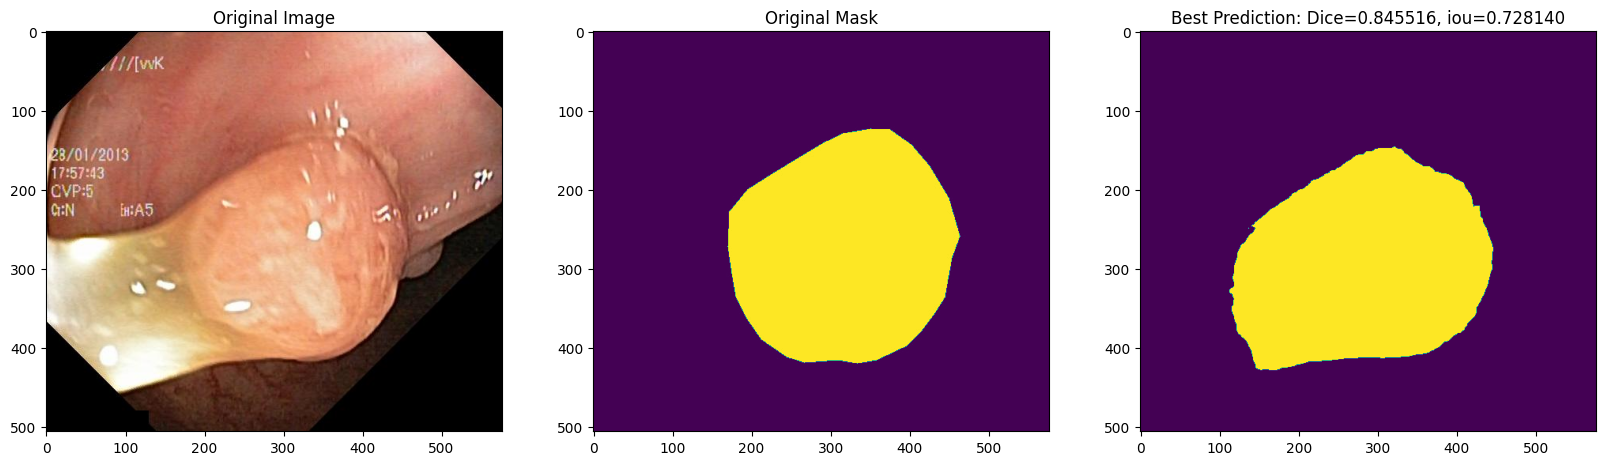

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

ax1.imshow(rescale_img(np_image))
ax1.set_title("Original Image")

ax2.imshow(last_mask)
ax2.set_title("Original Mask")

ax3.imshow(best_pred)
ax3.set_title(f"Best Prediction: Dice={dice:4f}, iou={iou:4f}");

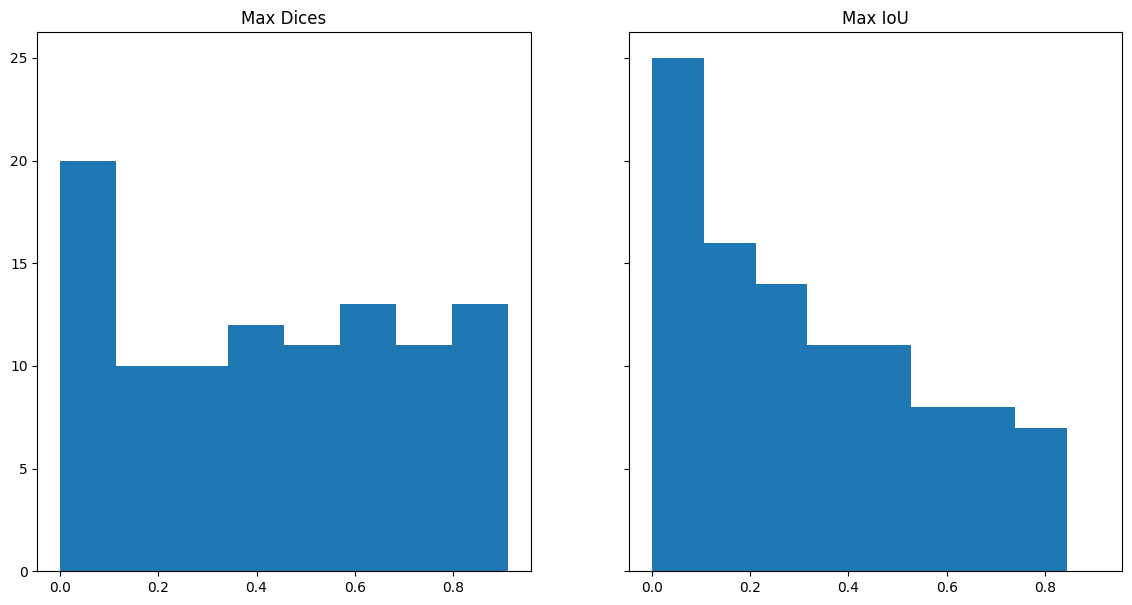

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(14, 7))

ax1.hist(max_dices, bins="auto")
ax1.set_title("Max Dices")

ax2.hist(max_ious, bins="auto")
ax2.set_title("Max IoU");

In [38]:
last_dices = f.cpu().numpy()
last_i

NameError: name 'last_i' is not defined

In [ ]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

autolocator = AutoMinorLocator()

ax1.hist(f.cpu().numpy(), bins=len(f))
ax1.yaxis.get_major_locator().set_params(integer=True)
ax1.yaxis.set_minor_locator(autolocator)
ax1.set_title("Max Dices")

ax2.hist(g.cpu().numpy(), bins=len(g))
ax2.yaxis.get_major_locator().set_params(integer=True)
ax2.yaxis.set_minor_locator(autolocator)
ax2.set_title("Max IoU");